## **Import libraries**

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from helper.helper import evaluate_model, plot_model_comparisons

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

In [4]:
raw_data_path = os.path.join("..", "data")

## **Load dataset**

### **Actions:**

- Defines the raw data path (../data).
- Constructs the full path to diabetes.csv.
- Checks if the file exists; raises FileNotFoundError if missing (prompts running 01_data_exploration.ipynb).
- Loads the dataset into a pandas DataFrame using pd.read_csv.
- Prints the file path and dataset shape (768 rows, 9 columns).
- Displays the first 5 rows using Colab’s table viewer (display(data.head())).

In [5]:
csv_file = os.path.join(raw_data_path, "diabetes.csv")
if not os.path.exists(csv_file):
    raise FileNotFoundError(f"CSV file not found at {csv_file}. Run 01_data_exploration.ipynb first.")
data = pd.read_csv(csv_file)
print(f"✅ Dataset loaded from: {csv_file}")
print("Shape:", data.shape)
display(data.head())  # Colab table viewer

✅ Dataset loaded from: ../data/diabetes.csv
Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### **Handle Zeros (Implicit Missing Values)**
- **Purpose**: Replace zeros in `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI` with median values.
- **Steps**:
  - Check if `handle_zeros` is enabled.
  - For each column (`Glucose`, etc.), count zeros (~35% in `Insulin`, ~30% in `SkinThickness` per EDA).
  - Replace zeros with the column’s median to address implicit missing values.
  - Print zero counts and percentages.
  - Display updated statistics for affected columns using Colab’s table viewer.

In [6]:
print("\n=== Handling Zeros ===")
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in zero_cols:
    zero_count = (data[col] == 0).sum()
    print(f"{col}: {zero_count} zeros ({zero_count/data.shape[0]:.2%})")
    data[col] = data[col].replace(0, data[col].median())
print("Zeros replaced with median values.")
display(data[zero_cols].describe())


=== Handling Zeros ===
Glucose: 5 zeros (0.65%)
BloodPressure: 35 zeros (4.56%)
SkinThickness: 227 zeros (29.56%)
Insulin: 374 zeros (48.70%)
BMI: 11 zeros (1.43%)
Zeros replaced with median values.


,Glucose,BloodPressure,SkinThickness,Insulin,BMI
count,768.000000,768.000000,768.000000,768.000000,768.000000
mean,121.656250,72.386719,27.334635,94.652344,32.450911
std,30.438286,12.096642,9.229014,105.547598,6.875366
min,44.000000,24.000000,7.000000,14.000000,18.200000
25%,99.750000,64.000000,23.000000,30.500000,27.500000
50%,117.000000,72.000000,23.000000,31.250000,32.000000
75%,140.250000,80.000000,32.000000,127.250000,36.600000
max,199.000000,122.000000,99.000000,846.000000,67.100000


### **Handle Class Imbalance with SMOTEENN**
- **Purpose**: Balance classes using SMOTEENN (oversampling + undersampling).
- **Steps**:
  - Check if `apply_smoteenn` is enabled.
  - Separate features (X) and target (y).
  - Apply SMOTEENN to training data (not test to avoid data leakage).
  - Print original and SMOTEENN class distributions (~65:35 to ~50:50).
  - Update data with resampled X and y.
  - Print new shape (~600–800 rows due to SMOTEENN’s undersampling).
  - Display resampled data using Colab’s table viewer.

In [7]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

- Performs a stratified train-test split using train_test_split:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## **Apply SMOTEENN for Class Imbalance**

In [9]:
smote_enn = SMOTEENN(random_state=42)
X_resampled_enn, y_resampled_enn = smote_enn.fit_resample(X_train, y_train)

In [10]:
X_resampled_enn

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,90,62,12,43.000000,27.200000,0.580000,24
1,5,126,78,27,22.000000,29.600000,0.439000,40
2,2,105,58,40,94.000000,34.900000,0.225000,25
3,0,95,64,39,105.000000,44.600000,0.366000,22
4,2,90,60,23,30.500000,23.500000,0.191000,25
...,...,...,...,...,...,...,...,...
432,7,175,89,33,299.726673,33.669023,0.466727,58
433,1,113,70,30,95.527785,35.194991,0.561299,32
434,0,119,85,48,226.830068,47.036274,0.479360,31
435,5,187,65,33,324.715245,31.698321,0.597522,29


## **Initialize Models and Results Dictionary**
Purpose: Define ML models for training and a dictionary to store evaluation results.

### **Actions:**

- Creates an empty results dictionary to store model performance metrics.
- Initializes three models:
    - `RandomForestClassifier (random_state=42).`
    - `KNeighborsClassifier (n_neighbors=5).`
    - `SVC (kernel='rbf', probability=True for ROC curves).`
- Stores models in a dictionary (models) with names as keys.

In [9]:
# Dictionary to hold results
results = {}

# Evaluate each model
rf_model = RandomForestClassifier(random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)
svm_model = SVC(kernel='rbf', probability=True)
models = {
    "Random Forest": rf_model,
    "KNN": knn_model,
    "SVM": svm_model
}

## **Train and Evaluate Models**
**Purpose:** Train each model on the resampled training data and evaluate performance.

### **Actions:**

- Loops through the models dictionary.
- For each model:
    - Sets `save_model=True` for Random Forest, `False` for others (saves only RF model).
    - Calls evaluate_model with:
        - Model instance.
        - Resampled training data (`X_resampled_enn, y_resampled_enn`).
        - `need_scaling=True` for KNN and SVM (assumes `evaluate_model` handles scaling internally).
        - `save` flag to save the Random Forest model.
    - Stores returned metrics (`fpr`, `tpr`, `roc_auc`, `acc`) in results[name].


🔍 RandomForestClassifier - Cross Validation Accuracy: 0.9371
🎯 Test Accuracy: 0.9545
🧾 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.95        38
           1       0.94      0.98      0.96        50

    accuracy                           0.95        88
   macro avg       0.96      0.95      0.95        88
weighted avg       0.96      0.95      0.95        88



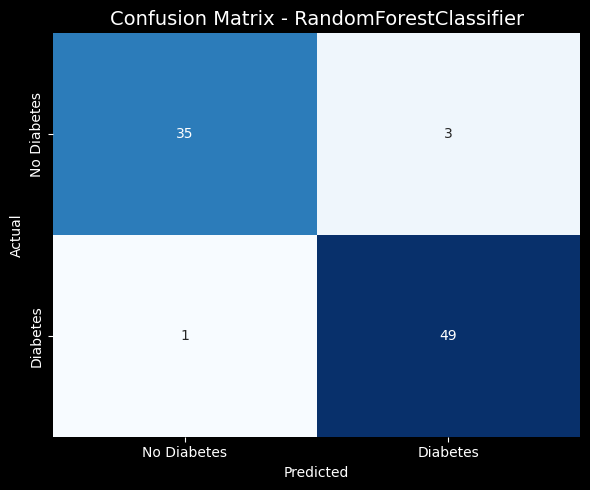


🔍 KNeighborsClassifier - Cross Validation Accuracy: 0.8999
🎯 Test Accuracy: 0.9432
🧾 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93        38
           1       0.91      1.00      0.95        50

    accuracy                           0.94        88
   macro avg       0.95      0.93      0.94        88
weighted avg       0.95      0.94      0.94        88



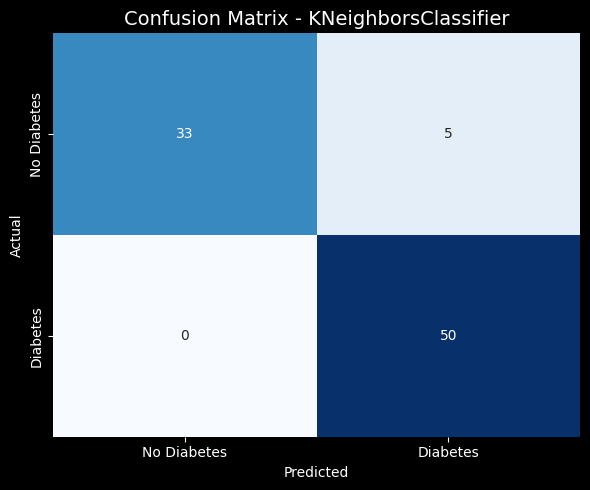


🔍 SVC - Cross Validation Accuracy: 0.9171
🎯 Test Accuracy: 0.9432
🧾 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93        38
           1       0.92      0.98      0.95        50

    accuracy                           0.94        88
   macro avg       0.95      0.94      0.94        88
weighted avg       0.94      0.94      0.94        88



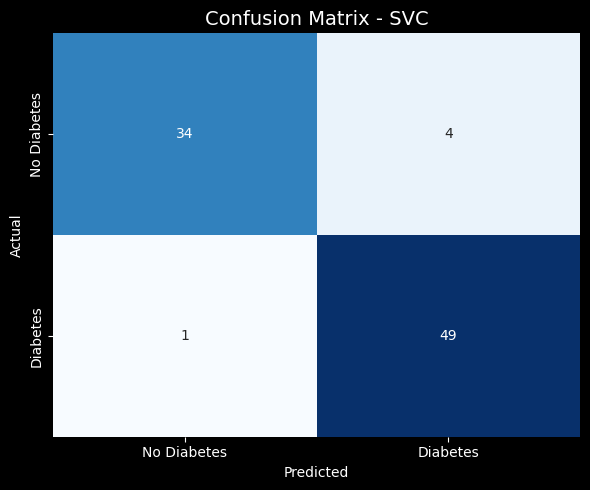

In [10]:
for name, model in models.items():
    save_model = True if name == "Random Forest" else False
    fpr, tpr, roc_auc, acc = evaluate_model(
        model, X_resampled_enn, y_resampled_enn, 
        need_scaling=(name in ["KNN", "SVM"]),
        save_model=save_model,
        save_scaler= True if name in ["KNN", "SVM"] else False
    )
    results[name] = (fpr, tpr, roc_auc, acc)

## **Plot Model Comparisons**
**Purpose:** Visualize model performance using ROC curves and other metrics.

### **Actions:**

- Calls `plot_model_comparisons(results)` to generate comparison plots.
- Assumes `plot_model_comparisons` (from `helper.helper`) uses the `results` dictionary to:
    - Plot ROC curves for each model using `fpr`, `tpr`, and `roc_auc`.
    - Possibly display accuracy or other metrics (e.g., bar plots).

/home/muhammad/Internship-Projects/Diabetes Prediction App/notebook/helper/helper.py:86: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/muhammad/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


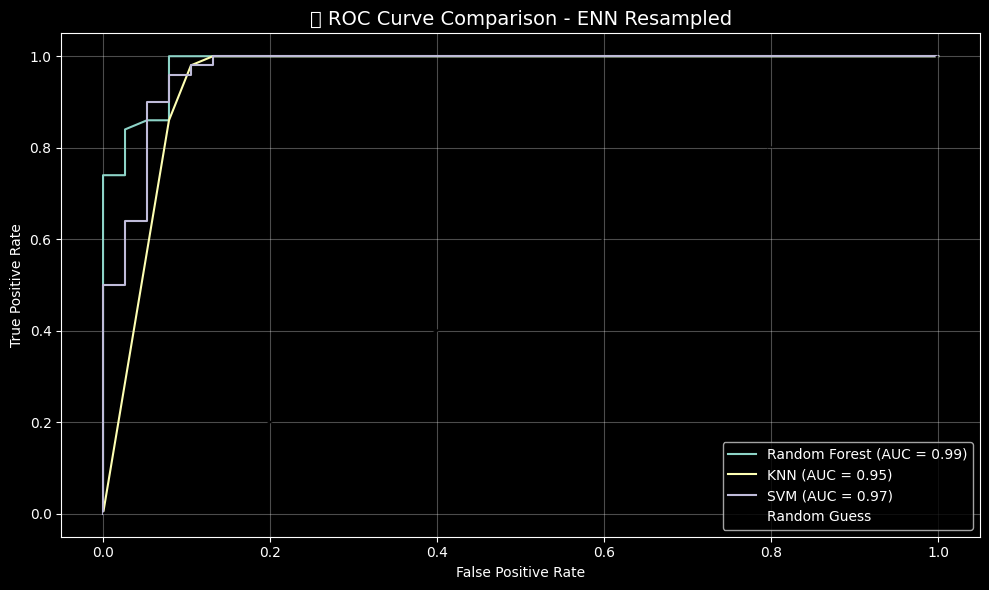

/home/muhammad/Internship-Projects/Diabetes Prediction App/notebook/helper/helper.py:98: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/muhammad/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


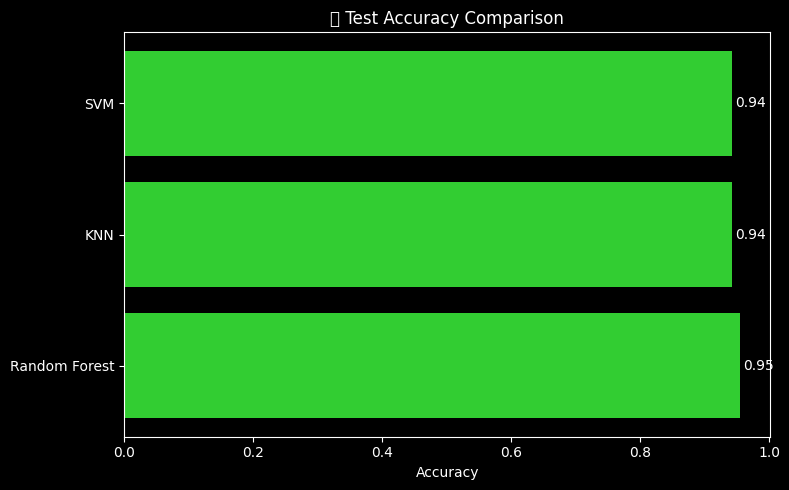

In [11]:
# Plot the comparisons
plot_model_comparisons(results)